### SETUP

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_io as tfio
import matplotlib.pyplot as plt
from IPython import display
from jiwer import wer, cer
import librosa
import datetime
import os

2024-06-04 11:20:47.971902: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 11:20:47.972069: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 11:20:48.044833: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-04 11:20:48.334125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-04 11:20:52.423111: W tensorflow/compiler/tf2

### Load the Holy-Quran Dataset

In [3]:
abs_path = os.path.abspath('')
data_path = abs_path + "/data"
wavs_path = data_path + "/audio112114/"
metadata_path = data_path + "/transcription_phonem112114.csv"


# Read metadata file and parse it
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "phonem"]
metadata_df = metadata_df[["file_name", "phonem"]]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(3)

,file_name,phonem
0,113004_19,wamin ʃari nafaa:θaa:ti fij lʕuqadi
1,112001_01,qul huwa lahu ʔaħadun
2,114002_15,maliki naa:si


In [4]:
split = int(len(metadata_df) * .8)
df_train = metadata_df[:split]
df_val = metadata_df[split:]

print(f"Size of the training set: {len(df_train)}")
print(f"Size of the validation set: {len(df_val)}")

Size of the training set: 124
Size of the validation set: 32


In [5]:
df_val.head()

,file_name,phonem
124,114003_16,ʔilahi naa:si
125,114002_01,maliki naa:si
126,113002_10,min ʃari maa: xalaqa
127,112002_16,lahu a:lsˤamadu
128,113001_10,qul ʔaʕuwðu birabi lfalaqi


### Preprocess the Data

In [6]:
# The set of characters accepted in the transcription.
characters = [x for x in "tljˤʒkʃθʔabnu: zwʕmqɣfrsxiðħdh"]
# Mapping characters to integers
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token="")
# Mapping integers back to original characters
num_to_char = keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

2024-06-04 03:01:04.325184: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 03:01:05.601366: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 03:01:05.601587: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 03:01:05.626010: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 03:01:05.626425: I external/local_xla/xla/stream_executor

The vocabulary is: ['', 't', 'l', 'j', 'ˤ', 'ʒ', 'k', 'ʃ', 'θ', 'ʔ', 'a', 'b', 'n', 'u', ':', ' ', 'z', 'w', 'ʕ', 'm', 'q', 'ɣ', 'f', 'r', 's', 'x', 'i', 'ð', 'ħ', 'd', 'h'] (size =31)


In [43]:
def load_16k_audio_tf(file):
    audio = tf.io.read_file(file)
    audio, sr = tf.audio.decode_wav(audio, desired_channels=1)
    sr = tf.cast(sr, tf.int64)
    audio = tf.squeeze(audio, axis=1)
    audio = tfio.audio.resample(audio, sr, 16000)
    return audio

In [7]:
# An integer scalar Tensor. The window length in samples. It is used to
# calculate the STFT of the signal.
fft_length = frame_length = 1024
# An integer scalar Tensor. The number of samples to step.
frame_step = 512
# The number of Mel frequency bins.
num_mel_bins = 128  # You can adjust this according to your needs
# sample_rate = 22050.0
# sample_rate = tf.cast(sample_rate, dtype=tf.float32)

In [69]:
@tf.function
def encode_single_sample_mel(wav_file, label):
    ###########################################
    # Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wavs_path + wav_file + ".wav")
    # 2. Decode the wav file
    audio, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    audio = tf.squeeze(audio, axis=1)
    # 3. Change type to float
    # audio = tf.cast(audio, tf.float32)
    # sample_rate = tf.cast(sample_rate, tf.float32)    
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    num_spectrogram_bins = spectrogram.shape[-1]
    # num_spectrogram_bins = tf.cast(num_spectrogram_bins, dtype=tf.float32)
    # 5. Create mel filter
    lowest_freq = 20.0
    high_freq = tf.cast(sample_rate / 2, dtype=tf.float32)
    mel_filter = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lowest_freq, high_freq
    )
    # 6. Apply the filter to the spectrogram
    mel_spectrogram = tf.tensordot(spectrogram, mel_filter, 1)
    # 7. Convert to db
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    # 8. normalisation
    means = tf.math.reduce_mean(mel_spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(mel_spectrogram, 1, keepdims=True)
    mel_spectrogram = (mel_spectrogram - means) / (stddevs + 1e-10)    
    ###########################################
    # Process the label
    ##########################################
    # 9. Convert label to Lower case
    label = tf.strings.lower(label)
    # 10. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 11. Map the characters in label to numbers
    label = char_to_num(label)
    # 12. Return a dict as our model is expecting two inputs
    return mel_spectrogram, label


In [70]:
for i in range(1):
    print(i)
    print(
        encode_single_sample_mel(df_train["file_name"].iloc[i], df_train["phonem"].iloc[i])
    )

0
(<tf.Tensor: shape=(566, 128), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.2460041 , -0.90259516,  0.8635127 , ...,  0.71820974,
         0.01432412, -0.3980564 ],
       ...,
       [ 0.66003776, -0.1737314 ,  0.13412991, ..., -1.6156994 ,
        -1.3798405 , -1.5845083 ],
       [ 0.8432086 ,  0.02093559,  0.6134786 , ..., -1.5195557 ,
        -1.6114508 , -1.3669164 ],
       [ 0.90679413,  0.07064781,  0.43934417, ..., -1.5097228 ,
        -1.4068038 , -1.3046263 ]], dtype=float32)>, <tf.Tensor: shape=(35,), dtype=int64, numpy=
array([17, 10, 19, 26, 12, 15,  7, 10, 23, 26, 15, 12, 10, 22, 10, 10, 14,
        8, 10, 10, 14,  1, 26, 15, 22, 26,  3, 15,  2, 18, 13, 20, 10, 29,
       26])>)


### Creating Dataset Objects

In [71]:
batch_size = 4
# Define the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_train["file_name"]), list(df_train["phonem"]))
)
train_dataset = (
    train_dataset.map(encode_single_sample_mel, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Define the validation dataset
validation_dataset = tf.data.Dataset.from_tensor_slices(
    (list(df_val["file_name"]), list(df_val["phonem"]))
)
validation_dataset = (
    validation_dataset.map(encode_single_sample_mel, num_parallel_calls=tf.data.AUTOTUNE)
    .padded_batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Sample rate seharusnya: 44100


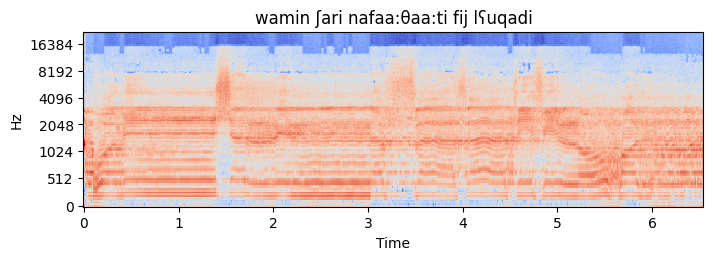

In [72]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    mel_spectrogram = batch[0][0].numpy()
    mel_spectrogram = np.array([np.trim_zeros(x) for x in np.transpose(mel_spectrogram)])
    label = batch[1][0]
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
    ax = plt.subplot(2, 1, 1)
    # ax.imshow(mel_spectrogram, vmax=1)
    ax.set_title(label)
    # ax.axis("off")
    # Wav
    file = tf.io.read_file(wavs_path + list(df_train["file_name"])[0] + ".wav")
    audio, sr = tf.audio.decode_wav(file)
    sr = sr.numpy()
    librosa.display.specshow(mel_spectrogram, sr=sr, x_axis="time", y_axis="mel")
    print(f"Sample rate seharusnya: {sr}")
    audio = audio.numpy()
    # ax = plt.subplot(2, 1, 2)
    # plt.plot(audio)
    # ax.set_title("Signal Wave")
    # ax.set_xlim(0, len(audio))
    display.display(display.Audio(np.transpose(audio), rate=sr))
plt.show()

### Model

In [77]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [95]:
class CWERMetric(tf.keras.metrics.Metric):
    """ A custom TensorFlow metric to compute the Character Error Rate
    """
    def __init__(self, name='CWER', **kwargs):
        super(CWERMetric, self).__init__(name=name, **kwargs)
        self.cer_accumulator = tf.Variable(0.0, name="cer_accumulator", dtype=tf.float32)
        self.wer_accumulator = tf.Variable(0.0, name="wer_accumulator", dtype=tf.float32)
        self.counter = tf.Variable(0, name="counter", dtype=tf.int32)

    def update_state(self, y_true, y_pred, sample_weight=None):
        input_shape = tf.keras.backend.shape(y_pred)

        input_length = tf.ones(shape=input_shape[0], dtype='int32') * tf.cast(input_shape[1], 'int32')

        decode, log = tf.keras.backend.ctc_decode(y_pred, input_length, greedy=True)

        decode = tf.keras.backend.ctc_label_dense_to_sparse(decode[0], input_length)
        y_true_sparse = tf.cast(tf.keras.backend.ctc_label_dense_to_sparse(y_true, input_length), "int64")

        decode = tf.sparse.retain(decode, tf.not_equal(decode.values, -1))
        distance = tf.edit_distance(decode, y_true_sparse, normalize=True)

        correct_words_amount = tf.reduce_sum(tf.cast(tf.not_equal(distance, 0), tf.float32))

        self.wer_accumulator.assign_add(correct_words_amount)
        self.cer_accumulator.assign_add(tf.reduce_sum(distance))
        self.counter.assign_add(len(y_true))

    def result(self):
        return {
                "CER": tf.math.divide_no_nan(self.cer_accumulator, tf.cast(self.counter, tf.float32)),
                "WER": tf.math.divide_no_nan(self.wer_accumulator, tf.cast(self.counter, tf.float32))
        }

In [96]:
def build_model(input_dim, output_dim, rnn_layers=5, rnn_units=128):
    """Build model based on the provided architecture."""
    # Model's input
    input_spectrogram = layers.Input((None, input_dim), name="input")
    
    # Expand the dimension to use 2D CNN.
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spectrogram)
    
    # First 2D Conv layer
    x = layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        name="conv_1"
    )(x)
    x = layers.LayerNormalization(name="ln_1")(x)
    x = layers.Activation("gelu", name="gelu_1")(x)
    x = layers.Dropout(0.1, name="dropout_1")(x)
    
    # Residual block with 2D Conv layers
    residual = x
    x = layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        name="conv_2"
    )(x)
    x = layers.LayerNormalization(name="ln_2")(x)
    x = layers.Activation("gelu", name="gelu_2")(x)
    x = layers.Dropout(0.1, name="dropout_2")(x)
    x = layers.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        padding="same",
        name="conv_3"
    )(x)
    x = layers.LayerNormalization(name="ln_3")(x)
    x = layers.Activation("gelu", name="gelu_3")(x)
    x = layers.Dropout(0.1, name="dropout_3")(x)
    
    # Adding the residual connection
    x = layers.Add(name="add")([x, residual])
    
    # Reshape the resulted volume to feed the RNNs layers
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    
    # RNN layers with BiGRU
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(
            units=rnn_units,
            activation="tanh",
            recurrent_activation="sigmoid",
            use_bias=True,
            return_sequences=True,
            reset_after=True,
            name=f"gru_{i}"
        )
        x = layers.Bidirectional(recurrent, name=f"bidirectional_{i}")(x)
        if i < rnn_layers:
            x = layers.LayerNormalization(name=f"ln_{i + 3}")(x)
            x = layers.Activation("gelu", name=f"gelu_{i + 3}")(x)
            x = layers.Dropout(0.1, name=f"dropout_{i + 3}")(x)
    
    # Classifier layers
    x = layers.Dense(units=rnn_units * 2, name="classifier_fc1")(x)
    x = layers.Activation("gelu", name="classifier_gelu")(x)
    x = layers.Dropout(0.1, name="classifier_dropout")(x)
    output = layers.Dense(units=output_dim + 1, activation="softmax", name="classifier_fc2")(x)
    
    # Model
    model = tf.keras.Model(input_spectrogram, output, name="RNN-CTC")
    
    # Compile the model and return
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=CTCLoss, metrics=[CWERMetric()])
    return model

In [97]:
# Get the model
model = build_model(
    input_dim=num_mel_bins,
    output_dim=char_to_num.vocabulary_size(),
    rnn_units=512,
)
model.summary(line_length=110)

Model: "RNN-CTC"
______________________________________________________________________________________________________________
 Layer (type)                    Output Shape                     Param #    Connected to                     
 input (InputLayer)              [(None, None, 128)]              0          []                               
                                                                                                              
 expand_dim (Reshape)            (None, None, 128, 1)             0          ['input[0][0]']                  
                                                                                                              
 conv_1 (Conv2D)                 (None, None, 128, 32)            320        ['expand_dim[0][0]']             
                                                                                                              
 ln_1 (LayerNormalization)       (None, None, 128, 32)            64         ['conv_1[0][0]']  

### Training and Evaluating

In [98]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = tf.keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    # Iterate over the results and get back the text
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text


# A callback class to output a few transcriptions during training
class CallbackEval(keras.callbacks.Callback):
    """Displays a batch of outputs after every epoch."""

    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def on_epoch_end(self, epoch: int, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = (
                    tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
                )
                targets.append(label)
        wer_score = wer(targets, predictions)
        print("-" * 100)
        print(f"Word Error Rate: {wer_score:.4f}")
        print("-" * 100)
        for i in np.random.randint(0, len(predictions), 2):
            print(f"Target    : {targets[i]}")
            print(f"Prediction: {predictions[i]}")
            print("-" * 100)

In [99]:
# Define the number of epochs.
epochs = 100
# Define the log directory for tensorboard
log_dir = "logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Callback function to check transcription on the val set.
validation_callback = CallbackEval(validation_dataset)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "model.h5", monitor="val_loss", save_best_only=True
)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[validation_callback, 
            tensorboard_callback,
            early_stopping, 
            checkpoint],
)

Epoch 1/100


2024-06-04 11:10:47.967840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/RNN-CTC/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-06-04 11:10:59.022989: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-04 11:11:29.372147: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-06-04 11:11:31.052890: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 345.49MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 11:11:32.179514: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocat

ResourceExhaustedError: Graph execution error:

Detected at node RNN-CTC/gelu_1/Gelu/mul_1 defined at (most recent call last):
  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_742/3077502242.py", line 15, in <module>

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/core/activation.py", line 59, in call

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/activations.py", line 348, in gelu

Detected at node RNN-CTC/gelu_1/Gelu/mul_1 defined at (most recent call last):
  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 359, in execute_request

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 446, in do_execute

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3048, in run_cell

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3103, in _run_cell

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3308, in run_cell_async

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3490, in run_ast_nodes

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3550, in run_code

  File "/tmp/ipykernel_742/3077502242.py", line 15, in <module>

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/core/activation.py", line 59, in call

  File "/home/progantara/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/activations.py", line 348, in gelu

2 root error(s) found.
  (0) RESOURCE_EXHAUSTED:  failed to allocate memory
	 [[{{node RNN-CTC/gelu_1/Gelu/mul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[GatherV2_1/_226]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) RESOURCE_EXHAUSTED:  failed to allocate memory
	 [[{{node RNN-CTC/gelu_1/Gelu/mul_1}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_100752]

2024-06-04 11:11:46.072337: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 635485900 of size 25165824 next 294
2024-06-04 11:11:46.072346: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 636c85900 of size 25165824 next 314
2024-06-04 11:11:46.072355: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 638485900 of size 25165824 next 315
2024-06-04 11:11:46.072363: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 639c85900 of size 6291456 next 328
2024-06-04 11:11:46.072372: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 63a285900 of size 6291456 next 329
2024-06-04 11:11:46.072381: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 63a885900 of size 3145728 next 330
2024-06-04 11:11:46.072390: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] InUse at 63ab85900 of size 3145728 next 331
2024-06-04 11:11:46.072398: I external/local_tsl/tsl/framework/bfc_allocator.cc:1095] I

### Inference

In [44]:
def decode_batch_prediction_without_ctc(pred):
    results = tf.argmax(pred, axis=2)
    output_text = []
    for res in results:
        print(num_to_char(res))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [11]:
# load model .h5
new_model = keras.models.load_model("models/model.h5", custom_objects={"CTCLoss": CTCLoss})
new_model.summary()

2024-06-01 14:16:25.968445: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "RNN-CTC"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, None, 128)]          0         []                            
                                                                                                  
 expand_dim (Reshape)        (None, None, 128, 1)         0         ['input[0][0]']               
                                                                                                  
 conv_1 (Conv2D)             (None, None, 128, 32)        320       ['expand_dim[0][0]']          
                                                                                                  
 ln_1 (LayerNormalization)   (None, None, 128, 32)        64        ['conv_1[0][0]']              
                                                                                            

In [24]:
# Let's check results on more validation samples
predictions = []
predictions_no_ctc = []
targets = []
for batch in validation_dataset:
    X, y = batch
    print(X.shape)
    batch_predictions = new_model.predict(X)
    print(batch_predictions.shape)
    batch_predictions_no_ctc = decode_batch_prediction_without_ctc(batch_predictions)
    batch_predictions_ctc = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions_ctc)
    predictions_no_ctc.extend(batch_predictions_no_ctc)
        
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        targets.append(label)
wer_score = wer(targets, predictions)
print("-" * 100)
print(f"Word Error Rate: {wer_score:.4f}")
print("-" * 100)
# for i in np.random.randint(0, len(predictions), 5):
for i in range(len(validation_dataset)):
    print(f"Target    : {targets[i]}")
    print(f"Prediction: {predictions[i]}")
    print(f"Prediction without CTC: {predictions_no_ctc[i]}")
    print("-" * 100)

(4, 274, 128)
1/1 [==============================] - 0s 471ms/step
(4, 274, 34)
tf.Tensor(
[b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'h' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'w' b'w' b'w' b'a' b'a' b'a' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'a' b'a' b':' b':' b'' b'' b'' b'' b'\xc9\xa3' b'u' b'u' b''
 b'' b'' b'' b'' b'b' b'' b'a' b'a' b'' b'' b'' b'' b'' b'' b'h' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'h' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'

In [52]:
@tf.function
def encode_single_sample_mel_mod(wav_file, label):
    ###########################################
    # Process the Audio
    ##########################################
    # 1. Read wav file
    file = tf.io.read_file(wav_file)
    # 2. Decode the wav file
    audio, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    audio = tf.squeeze(audio, axis=1)
    # 3. Change type to float
    # audio = tf.cast(audio, tf.float32)
    # sample_rate = tf.cast(sample_rate, tf.float32)    
    # 4. Get the spectrogram
    spectrogram = tf.signal.stft(
        audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length
    )
    spectrogram = tf.abs(spectrogram)
    num_spectrogram_bins = spectrogram.shape[-1]
    # num_spectrogram_bins = tf.cast(num_spectrogram_bins, dtype=tf.float32)
    # 5. Create mel filter
    lowest_freq = 20.0
    high_freq = tf.cast(sample_rate / 2, dtype=tf.float32)
    mel_filter = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins, num_spectrogram_bins, sample_rate, lowest_freq, high_freq
    )
    # 6. Apply the filter to the spectrogram
    mel_spectrogram = tf.tensordot(spectrogram, mel_filter, 1)
    # 7. Convert to db
    mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)
    # 8. normalisation
    means = tf.math.reduce_mean(mel_spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(mel_spectrogram, 1, keepdims=True)
    mel_spectrogram = (mel_spectrogram - means) / (stddevs + 1e-10)    
    ###########################################
    # Process the label
    ##########################################
    # 9. Convert label to Lower case
    label = tf.strings.lower(label)
    # 10. Split the label
    label = tf.strings.unicode_split(label, input_encoding="UTF-8")
    # 11. Map the characters in label to numbers
    label = char_to_num(label)
    # 12. Return a dict as our model is expecting two inputs
    return mel_spectrogram, label


In [155]:
# inference single file
file_name = "test_data/078001_01_mute_1.wav"
transcription = "ʕama jatasa:ʔaluwna"

In [156]:
# play audio and wave form
file = tf.io.read_file(file_name)
audio, sr = tf.audio.decode_wav(file)
sr = sr.numpy()
audio = audio.numpy()
duration = len(audio) / sr
print(f"Sample Rate: {sr} sample")
print(f"Total samples: {len(audio)} sample")
print(f"Duration: {duration} seconds")
display.display(display.Audio(np.transpose(audio), rate=sr))

Sample Rate: 22050 sample
Total samples: 127296 sample
Duration: 5.773061224489796 seconds


In [157]:
# run inference on a sample
X, y = encode_single_sample_mel_mod(file_name, transcription)
time_per_frame = duration / X.shape[0]
print(f"Time per frame: {time_per_frame:.4f} seconds")
print(f"Number of frames: {X.shape[0]}")
print(f"Total duration: {time_per_frame * X.shape[0]} seconds")

X = tf.expand_dims(X, 0)
batch_predictions = new_model.predict(X)
batch_predictions_ctc = decode_batch_predictions(batch_predictions)
batch_predictions_no_ctc = decode_batch_prediction_without_ctc(batch_predictions)
print(f"Target    : {transcription}")
print(f"Prediction: {batch_predictions_ctc[0]}")
print(f"Prediction without CTC: {batch_predictions_no_ctc[0]}")

Time per frame: 0.0236 seconds
Number of frames: 245
Total duration: 5.773061224489796 seconds
1/1 [==============================] - 1s 1s/step
tf.Tensor(
[b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b't' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'z' b''
 b'' b'' b'' b'a' b'a' b'a' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b''
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'a' b'a'
 b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'' b'a' b'a'
 b'a' b':' b':' b':' b'' b'' b'' b'\xca\x94' b'a' b'a' b'' b'' b'' b'' b''
 b'' b'' b'l' b'' b'u' b'u' b'' b'' b'